<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse through the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install osmnx==0.13.0 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 11 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-underscore all 1.8.3~dfsg-1 [59.9 kB]
Get:4 htt

In [2]:
import os,os.path
from glob import glob
from shutil import copyfile

import fiona
from shapely.geometry import shape, mapping, Point
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from numpy import arange
import numpy as np

# optimization-related
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/My\ Drive/StreetPsych

Chicago  HydePark  key.txt


In [8]:
#place_name = "Chicago, Illinois, USA"
#place_name = "Hyde Park, Chicago, Illinois, USA"
place_name = "Brookline, Massachusetts, USA"

graph = ox.graph_from_place(place_name, network_type='walk')

In [9]:
#location = 'HydePark' 
#location = 'Chicago'

location = 'Brookline_MA'

#ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/Chicago')
ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/' + location)

In [10]:
files = glob("drive/My Drive/StreetPsych/" + location + "/*")
print(files)

['drive/My Drive/StreetPsych/Brookline_MA/nodes.shp', 'drive/My Drive/StreetPsych/Brookline_MA/nodes.shx', 'drive/My Drive/StreetPsych/Brookline_MA/nodes.dbf', 'drive/My Drive/StreetPsych/Brookline_MA/nodes.cpg', 'drive/My Drive/StreetPsych/Brookline_MA/nodes.prj', 'drive/My Drive/StreetPsych/Brookline_MA/edges.shp', 'drive/My Drive/StreetPsych/Brookline_MA/edges.shx', 'drive/My Drive/StreetPsych/Brookline_MA/edges.dbf', 'drive/My Drive/StreetPsych/Brookline_MA/edges.cpg', 'drive/My Drive/StreetPsych/Brookline_MA/edges.prj']


In [11]:
if not os.path.exists('source'):
  os.mkdir('source')

In [12]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'source/' + os.path.basename(f))

drive/My Drive/StreetPsych/Brookline_MA/nodes.shp
drive/My Drive/StreetPsych/Brookline_MA/nodes.shx
drive/My Drive/StreetPsych/Brookline_MA/nodes.dbf
drive/My Drive/StreetPsych/Brookline_MA/nodes.cpg
drive/My Drive/StreetPsych/Brookline_MA/nodes.prj
drive/My Drive/StreetPsych/Brookline_MA/edges.shp
drive/My Drive/StreetPsych/Brookline_MA/edges.shx
drive/My Drive/StreetPsych/Brookline_MA/edges.dbf
drive/My Drive/StreetPsych/Brookline_MA/edges.cpg
drive/My Drive/StreetPsych/Brookline_MA/edges.prj


In [13]:
!ls source

edges.cpg  edges.prj  edges.shx  nodes.dbf  nodes.shp
edges.dbf  edges.shp  nodes.cpg  nodes.prj  nodes.shx


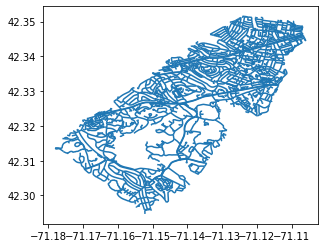

In [14]:
osm_map = gpd.read_file('source/edges.shp')
osm_map.plot()

In [15]:
osm_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         3340 non-null   int64   
 1   v         3340 non-null   int64   
 2   key       3340 non-null   int64   
 3   osmid     3340 non-null   object  
 4   lanes     2020 non-null   object  
 5   name      2025 non-null   object  
 6   highway   3340 non-null   object  
 7   width     2129 non-null   object  
 8   oneway    3340 non-null   int64   
 9   length    3340 non-null   float64 
 10  from      3340 non-null   int64   
 11  to        3340 non-null   int64   
 12  maxspeed  748 non-null    object  
 13  ref       94 non-null     object  
 14  access    173 non-null    object  
 15  bridge    12 non-null     object  
 16  tunnel    4 non-null      object  
 17  junction  24 non-null     object  
 18  service   119 non-null    object  
 19  geometry  3340 non-null   geometry
dtype

In [16]:
#print(osm_map.osmid.head())
#print(osm_map.u.head())
#print(osm_map.v.head())
#print(osm_map['from'].head())
#print(osm_map.to.head())

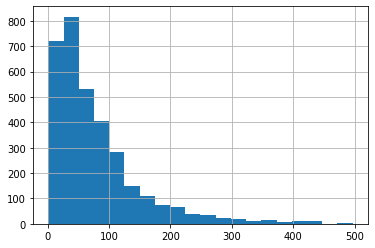

In [17]:
#osm_map_flt['osmid']
#osm_map_flt['geometry'].iloc[0]
valid = (osm_map['length'] < 500)
osm_map.loc[valid, 'length'].hist(bins=20)

In [18]:
len_4326 = []
len_meter = []
num_coords = []

for index, row in osm_map.iterrows():
  line = row['geometry']
  num_coords.append(len(line.coords))
  len_4326.append(line.length)
  len_meter.append(row['length']) # in meters

In [19]:
quick_df = pd.DataFrame({'num_coords': num_coords, 'len_4326':len_4326, 'len_meter':len_meter})
quick_df['ratio'] = quick_df['len_4326'] / quick_df['len_meter']

In [20]:
quick_df.describe()

,num_coords,len_4326,len_meter,ratio
count,3340.000000,3340.000000,3340.000000,3340.000000
mean,5.181437,0.000864,80.444340,0.000011
std,4.964626,0.000903,82.689328,0.000001
min,2.000000,0.000010,1.045000,0.000009
25%,2.000000,0.000309,29.496750,0.000010
50%,3.000000,0.000592,56.191000,0.000011
75%,6.000000,0.001087,102.641000,0.000012
max,87.000000,0.010111,960.765000,0.000012


In [21]:
def sample_points(input_osm, sample_dist, verbose=False):

  # load the shape file: should be edges
  osm_map = input_osm # gpd.read_file(shapefile)

  # filter the load
  flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ',
              'pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk',
              'secondary','secondary_link','tertiary_link','bridleway','service']

  # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
  flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)
  osm_map_flt = osm_map[flt_idx]
  if verbose:
    print('Filtering done: all rows', len(flt_idx), ', after: ', sum(flt_idx))

  # get bearing for each road
  #osm_map_flt['bearing'] = osm_map_flt['geometry'].apply(lambda line: round(ox.bearing.get_bearing(line.coords[0], line.coords[1])))

  # get the minimum distance in EPSG:4326
  ratio = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    ratio.append(line.length / row['length'])
  sample_dist_4326 = sample_dist * sum(ratio) / len(ratio)

  # sampling the points
  count = 0
  results = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    
    # if the street is too short 1.5*sampling dist, then pass 
    if line.length > 1.3*sample_dist_4326:
      # sample points      
      points = [line.interpolate(dist) for dist in arange(sample_dist_4326/4, line.length, sample_dist_4326/2)]

      # get bearings too
      for ii in range(1,len(points)-1,2):
        # points, bearing, osm line reference
        results.append([points[ii], 
                        ox.bearing.get_bearing(points[ii-1].coords[0][::-1], points[ii+1].coords[0][::-1]),
                        index])

    count += 1
    if verbose & (count % 1000 == 0):
      print('Processed: ', count, ', points: ', len(results))

  if verbose:
    print('Processed (done): ', count, ', points: ', len(results))

  return results


In [23]:
input_osm = gpd.read_file('source/edges.shp')

%timeit points = sample_points(input_osm, 50)

points = sample_points(input_osm, 50, verbose=True)

1 loop, best of 3: 324 ms per loop
Filtering done: all rows 3340 , after:  1091
Processed:  1000 , points:  1320
Processed (done):  1091 , points:  1410


In [24]:
picked_gdf = gpd.GeoDataFrame(
    pd.DataFrame(points, columns=['geometry', 'bearing', 'osm_index']),
    geometry = 'geometry'
)
picked_gdf.head()

,geometry,bearing,osm_index
0,POINT (-71.12575 42.32774),233.914886,0
1,POINT (-71.14738 42.30898),111.039266,1
2,POINT (-71.14660 42.30838),333.033300,3
3,POINT (-71.16452 42.31286),285.269836,21
4,POINT (-71.16503 42.31303),303.632335,21


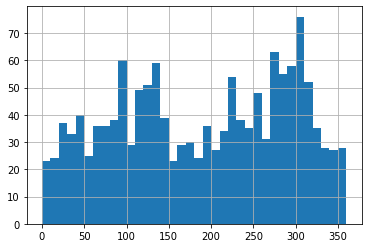

In [25]:
picked_gdf['bearing'].hist(bins=36)

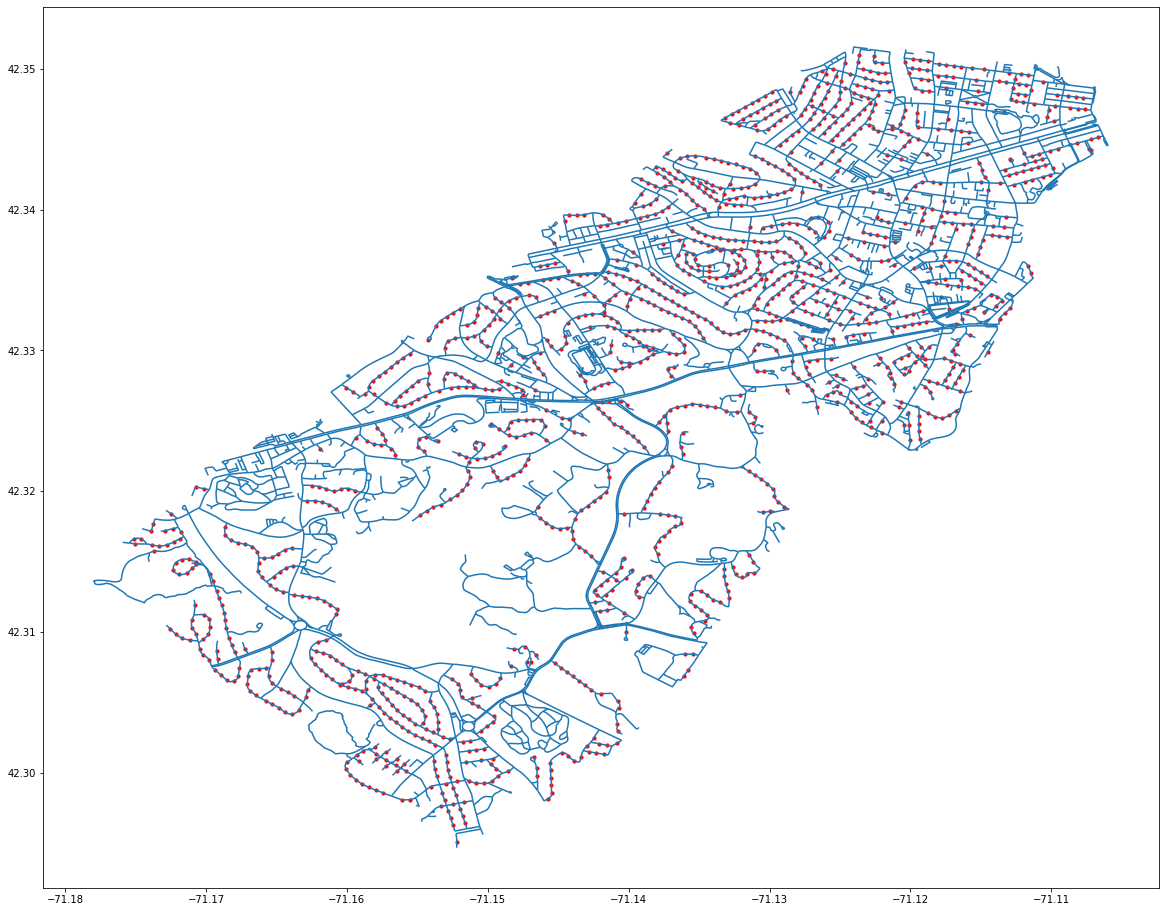

In [26]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)

In [27]:
# save to file
#picked_gdf.to_csv('drive/My Drive/StreetPsych/' + location + '/seed_' + location + '.csv')

In [28]:
picked_gdf['lat'] = [row[0].coords[0][1] for row in points]
picked_gdf['lng'] = [row[0].coords[0][0] for row in points]
picked_gdf

,geometry,bearing,osm_index,lat,lng
0,POINT (-71.12575 42.32774),233.914886,0,42.327738,-71.125754
1,POINT (-71.14738 42.30898),111.039266,1,42.308979,-71.147382
2,POINT (-71.14660 42.30838),333.033300,3,42.308377,-71.146599
3,POINT (-71.16452 42.31286),285.269836,21,42.312865,-71.164519
4,POINT (-71.16503 42.31303),303.632335,21,42.313030,-71.165028
...,...,...,...,...,...
1405,POINT (-71.11600 42.33280),60.352672,3264,42.332801,-71.115996
1406,POINT (-71.11550 42.33301),60.352591,3264,42.333009,-71.115501
1407,POINT (-71.15046 42.30090),259.672377,3265,42.300896,-71.150459
1408,POINT (-71.12575 42.33213),117.124299,3304,42.332130,-71.125745


In [29]:
picked_gdf.to_csv('drive/My Drive/StreetPsych/' + location + '/seed_' + location + '.csv')

# Checking the GSV coordinates vs. original samples

In [ ]:
combined_df = pd.read_csv('drive/My Drive/StreetPsych/' + location + '/gsv_seed_' + location + '.csv')
combined_df.head()

,Unnamed: 0,lat,lng,bearing,osm_index,gsv_lat,gsv_lng,pano_id,date,status
0,0,41.792784,-87.581656,96.841944,0,41.792797,-87.581747,GHRFbz2JAAvkDmWHU7oswA,2011-06,OK
1,1,41.792707,-87.581137,103.889035,0,41.792710,-87.581160,ufrhNaqGu6SQVbLVgT_w_w,2011-06,OK
2,2,41.788646,-87.584262,113.243840,4,41.788594,-87.584125,wEtBw3PTguAUA2oyo0hs-Q,2011-06,OK
3,3,41.788562,-87.583745,96.709815,4,41.788553,-87.583791,zMSXwtuYNfe_W-N5telkzA,2011-06,OK
4,4,41.788525,-87.583221,110.335822,4,41.788504,-87.583216,aLoxEIp1Jaw6-i7KNE74Lw,2011-06,OK


In [ ]:
sum(combined_df['date'] > '2019-01')

319

In [ ]:
geometry = [Point(xy) for xy in zip(combined_df['gsv_lng'], combined_df['gsv_lat'])]

In [ ]:
#osm_map.crs
gsv_gdf = gpd.GeoDataFrame(combined_df, geometry=geometry)

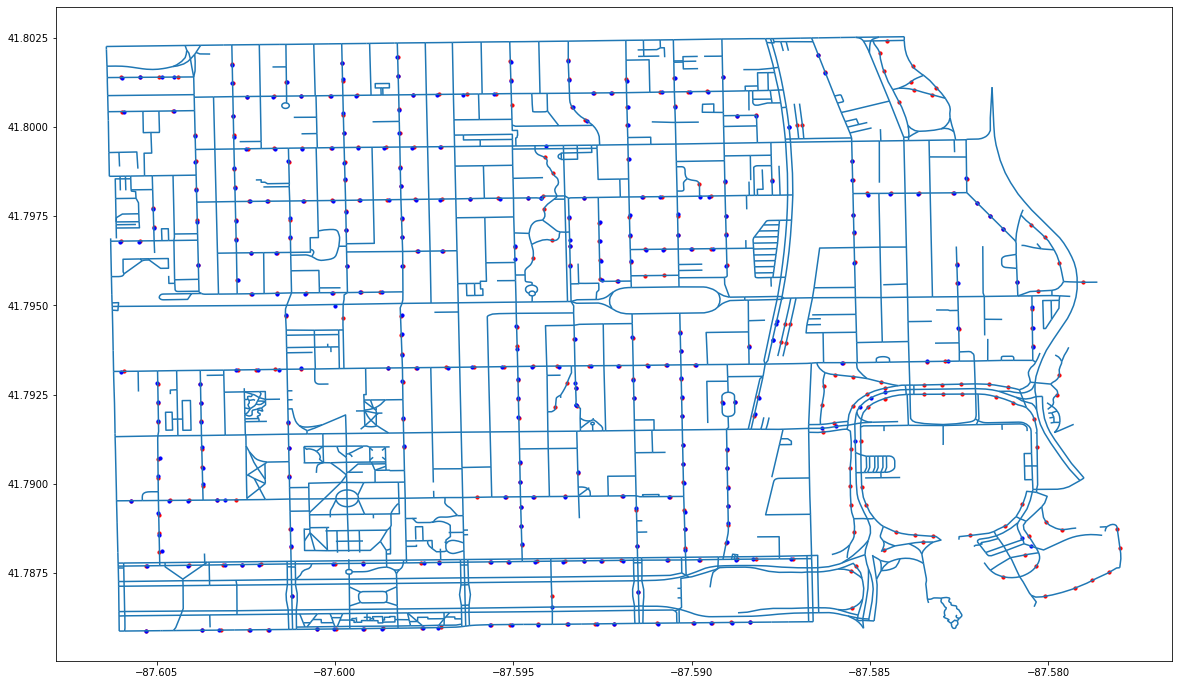

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)
gsv_gdf[gsv_gdf['date'] > '2019-01'].plot(ax=ax, color='blue', markersize=10)